# Runoff Onset for the Sierra Nevada Ecoregion and Upper Tuolumne Watershed 

In [1]:
!pip install -q odc-stac -U

In [2]:
# imports
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
import matplotlib
import ipyleaflet
import sys
import os
import dask_gateway
import planetary_computer
from rechunker import rechunk
sys.path.append('../../../sar_snowmelt_timing')
import s1_rtc_bs_utils
import contextily as ctx
import rioxarray as rxr
import skimage
import pathlib
import glob
import re
import time
import fsspec

In [3]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.adapt(minimum=90, maximum=100)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.1e86e31e506d46a7b247bfdd68e4cfbb/status


In [4]:
gj = 'shapefiles/SierraNevada_ecoregion.shp' 
area_name = 'sierra_nevada'
resolution = 80 # for this large ecoregion, and with 80m res, only process with vv

gj = 'shapefiles/18040009_HU8.geojson' # geojson extracted from NHD_H_18040009_HU8_GPKG.gpkg, which was downloaded from https://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Hydrography/NHD/HU8/GPKG/
area_name = 'upper_tuolumne_watershed' # https://snoflo.org/hydrology/watershed-h18040009-upper-tuolumne
resolution = 20

bbox_gdf = gpd.read_file(gj)
bbox_gdf = bbox_gdf.set_crs('EPSG:4326')

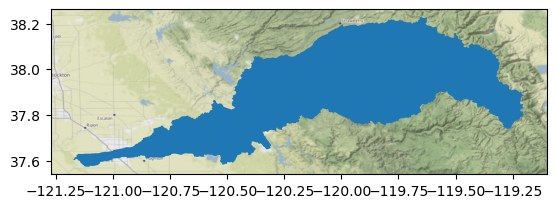

In [5]:
f,ax=plt.subplots()
bbox_gdf.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=bbox_gdf.crs, source=ctx.providers.Stamen.Terrain,attribution=False)

In [6]:
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_odc_pc(bbox_gdf,start_time='2015-01-01',end_time='2015-02-01',resolution=resolution)

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [7]:
ts_ds

<xarray.DataArray (time: 7, band: 1, y: 3825, x: 8669)>
dask.array<rechunk-merge, shape=(7, 1, 3825, 8669), dtype=float32, chunksize=(7, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y                   (y) float64 4.237e+06 4.237e+06 ... 4.16e+06 4.16e+06
  * x                   (x) float64 6.611e+05 6.612e+05 ... 8.345e+05 8.345e+05
    spatial_ref         int32 32610
  * time                (time) datetime64[ns] 2015-01-07T01:58:59.259316 ... ...
    sat:orbit_state     (time) <U10 dask.array<chunksize=(7,), meta=np.ndarray>
    sat:relative_orbit  (time) int64 dask.array<chunksize=(7,), meta=np.ndarray>
  * band                (band) object 'vv'
Attributes:
    resolution:  20

In [8]:
years = [2015,2016,2017,2018,2019,2020,2021,2022,2023]

In [9]:
snow_classes = [ # https://zenodo.org/record/2626737#.ZDMMf3bMIQ8
#    0, #Little-to-no snow
    1, #Indeterminate due to clouds
    2, #Ephemeral snow
    3, #Seasonal snow
]

classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf
#    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
#    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
#    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]

In [10]:
worldcover = s1_rtc_bs_utils.get_worldcover(ts_ds.isel(time=0))

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [11]:
worldcover

<xarray.DataArray 'map' (y: 3825, x: 8669)>
array([[30, 40, 40, ..., 10, 10, 10],
       [40, 40, 30, ..., 10, 10, 10],
       [40, 30, 30, ..., 10, 10, 10],
       ...,
       [40, 40, 40, ..., 10, 10, 10],
       [40, 40, 40, ..., 10, 10, 10],
       [40, 40, 40, ..., 10, 10, 10]], dtype=uint8)
Coordinates:
  * x            (x) float64 6.611e+05 6.612e+05 ... 8.345e+05 8.345e+05
  * y            (y) float64 4.237e+06 4.237e+06 4.237e+06 ... 4.16e+06 4.16e+06
    time         datetime64[ns] 2021-01-01
    spatial_ref  int64 0
Attributes:
    _FillValue:  0

In [12]:
snow_mask = s1_rtc_bs_utils.get_snowmask(ts_ds.isel(time=0))

In [13]:
snow_mask

<xarray.DataArray (y: 3825, x: 8669)>
array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [255, 255,   0, ...,   3,   3,   3],
       [255, 255,   0, ...,   3,   3,   3],
       [255, 255,   0, ...,   3,   3,   3]], dtype=uint8)
Coordinates:
  * x            (x) float64 6.611e+05 6.612e+05 ... 8.345e+05 8.345e+05
  * y            (y) float64 4.237e+06 4.237e+06 4.237e+06 ... 4.16e+06 4.16e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     255

In [14]:
for year in years:
    year = 2017
    print(f'working on {year}...')
    tic = time.perf_counter()
    
    ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_odc_pc(bbox_gdf,start_time=f'{year}-02-01',end_time=f'{year}-07-31',resolution=resolution)
    #ts_ds = ts_ds.sel(band='vv')
    
    ts_ds = ts_ds.where(worldcover.isin(classes))
    ts_ds = ts_ds.where(snow_mask.isin(snow_classes))
    ts_ds = ts_ds.rio.clip(bbox_gdf.geometry.values,bbox_gdf.crs)
    

    runoffs_median = s1_rtc_bs_utils.get_runoff_onset(ts_ds)
    runoffs_median_computed_doy = runoffs_median.dt.dayofyear.compute()
    runoffs_median_computed_doy = runoffs_median_computed_doy.where(runoffs_median_computed_doy>0).rio.write_nodata(-32768,encoded=True)
    runoffs_median_computed_doy.rio.write_crs(ts_ds.rio.crs,inplace=True)
    
    runoffs_median_computed_doy.rio.to_raster(f'output/runoff_onset_{area_name}_{year}_{resolution}m.tif',driver="COG", dtype='int16')
    
    toc = time.perf_counter()
    print(f'File created. Processing time: {toc - tic:0.1f} seconds')

working on 2017...


/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/con

File created. Processing time: 270.9 seconds
working on 2017...


/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/srv/con